# imports

In [33]:
import os
import pickle
import warnings
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from os.path import join, dirname, abspath, basename
from moseq2_app.gui.progress import update_progress, restore_progress_vars
from moseq2_viz.model.util import relabel_by_usage, parse_model_results, compute_syllable_explained_variance
from moseq2_viz.model.trans_graph import get_trans_graph_groups, get_group_trans_mats,  get_transition_matrix
from moseq2_viz.util import parse_index, read_yaml
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.util import compute_behavioral_statistics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

In [21]:
# plot/colors definitions
cpath = os.getcwd() #assumes all files are in the same path as the notebook
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")

## generate permutation

In [22]:
# add back labels
index_data = read_yaml(cpath+'/moseq2-index.yaml')

with open('uuid_include.pkl', 'rb') as f:
    uuid_include = pickle.load(f)
    
uuid_cage = {}
uuid_mouse = {}
uuid_phase = {}
for file in index_data['files']:
    if file['uuid'] in uuid_include:
        uuid_cage[file['uuid']] = file['metadata']['SubjectName'][:2]
        uuid_mouse[file['uuid']] = file['metadata']['SubjectName'][:5]
        uuid_phase[file['uuid']] = file['group']

In [ ]:
# syllable threshold defined above. Uncomment if you want to manually set
max_syllables = 58

# select a transition matrix normalization method
normalize = 'bigram' # options: bigram, columns, rows

# load your model
model_path = cpath+'/model-001-none.p'
model_data = parse_model_results(model_path)
model_data['labels'] = relabel_by_usage(model_data['labels'], count='usage')[0]
index_keep = [i for i, uuid in enumerate(model_data['keys']) if uuid in uuid_include]
model_data['labels']=np.array(model_data['labels'])[index_keep]
model_data['keys'] = np.array(model_data['keys'])[index_keep]
model_data['train_ll'] = np.array(model_data['train_ll'])[index_keep]
model_data['train_list'] = np.array(model_data['train_list'])[index_keep]
model_data['metadata']['groups'] = uuid_phase

def rle(array):
    rle_array = [array[0]]
    for i in range(1, len(array)):
        if array[i] !=array[i-1]:
            rle_array.append(array[i])
    return rle_array

model_uuids = model_data.get('train_list',model_data['keys'])
label_group = [model_data['metadata']['groups'][k] for k in model_uuids]

group = sorted([g for g in list(set(label_group)) if 'NA' not in g])

rle_lbls = [np.array(rle(lbl)) for lbl in model_data['labels']]

trans_mats_permutations = []
rle_lbls_p = [np.array(rle(lbl))[1:] for lbl in model_data['labels']]

for i in tqdm(range(2000)):
    temp_array = []
    for arr in rle_lbls:
        temp_array.append(np.insert(np.random.permutation(arr), 0, -5))
    trans_mats, _ = get_group_trans_mats(temp_array, label_group, group, max_syllables, normalize=normalize)
    trans_mats_permutations.append(trans_mats)
trans_mats_permutations = np.array(trans_mats_permutations)
# np.save('tm_permute_58',trans_mats_permutations)


## Find significant bigrams

In [ ]:
#mice that have at least 3 phases and 10 repetitions each
keep_mice = ['03_03', '02_01', '04_01', '01_03', '02_04', '01_01', '03_04', '04_02', '02_02', '04_03', '01_02', '03_01', '04_04', '02_03']

# add back labels
index_data = read_yaml(cpath+'/moseq2-index.yaml')

uuid_cage = {}
uuid_mouse = {}
uuid_phase = {}
for file in index_data['files']:
    if file['uuid'] in uuid_include:
        uuid_cage[file['uuid']] = file['metadata']['SubjectName'][:2]
        uuid_mouse[file['uuid']] = file['metadata']['SubjectName'][:5]
        uuid_phase[file['uuid']] = file['group']

uuid_include = [k for k, v in uuid_mouse.items() if v in keep_mice]

# syllable threshold defined above. Uncomment isf you want to manually set
max_syllables = 58
# max_syllables = 40

# select a transition matrix normalization method
normalize = 'bigram' # options: bigram, columns, rows

# load your model
model_path = cpath+'/model-001-none.p'
model_data = parse_model_results(model_path)
model_data['labels'] = relabel_by_usage(model_data['labels'], count='usage')[0]
index_keep = [i for i, uuid in enumerate(model_data['keys']) if uuid in uuid_include]
model_data['labels']=np.array(model_data['labels'])[index_keep]
model_data['keys'] = np.array(model_data['keys'])[index_keep]
model_data['train_ll'] = np.array(model_data['train_ll'])[index_keep]
model_data['train_list'] = np.array(model_data['train_list'])[index_keep]
model_data['metadata']['groups'] = uuid_phase

mouse_data = [uuid_mouse[k] for k in model_data['keys']]
phase_data = [uuid_phase[k] for k in model_data['keys']]

# apply run-length encoding to the labels
model_uuids = model_data.get('train_list',model_data['keys'])
label_group = [model_data['metadata']['groups'][k] for k in model_uuids]
group = sorted([g for g in list(set(label_group)) if 'NA' not in g])
rle_lbls = [np.array(rle(lbl)) for lbl in model_data['labels']]

# loading pre-computed permutation results
trans_mats_permutations = np.load(cpath+'/tm_permute_58.npy')

trans_mats_permutations = np.mean(trans_mats_permutations, axis = 1)

tm_std = np.std(trans_mats_permutations, axis = 0) *2
tm_mean = np.mean(trans_mats_permutations, axis= 0)

tm_mean_plus = tm_mean + tm_std
tm_mean_minus = tm_mean - tm_std

trans_mats, usages = get_group_trans_mats(rle_lbls, label_group, group, max_syllables, normalize=normalize)
tm_real = np.array(trans_mats)

significant_tm = np.any([tm_real >= tm_mean_plus, tm_real <=tm_mean_minus], axis=0).astype(int)
tm_real_mean = np.mean(tm_real, axis = 0)
significant_tm_overall = np.any([tm_real_mean >= tm_mean_plus,  tm_real_mean <= tm_mean_minus], axis = 0)

select = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
          10,11,12,13,14,15,16,17,18,19,
          20,21,22,23,24,25,26,27,28,29,
          30,31,32,33,34,35,36,37,38,39,
          40,41,42,43,44,45,46,47,49] # syllable 49 is refered to in the manuscript and mean_df_female as 48 for clarity

tm_data_sig = []
y = []
for index, label in enumerate(model_data['labels']):
    tm = get_transition_matrix(label)[0][:max_syllables, :max_syllables]
    y.append(label_group[index])
    tm = tm * significant_tm_overall
    tm = tm[select][:, select]
    tm_data_sig.append(tm)
    
tm_data_sig = np.array(tm_data_sig)
tm_data_sig = np.reshape(tm_data_sig, (len(uuid_include), 49*49))
tm_data_sig =tm_data_sig/tm_data_sig.sum(1)[:,np.newaxis]
print(np.sum(tm_data_sig), np.all(np.isnan(tm_data_sig)))
tm_data_sig = pd.DataFrame(tm_data_sig)
tm_data_sig['group'] = phase_data
tm_data_sig['mouse'] = mouse_data


## decode phase

In [35]:
it=1000
leave = 'mouse'
predict='group'
minum=10

In [36]:
#decoder
clf = RandomForestClassifier(n_estimators = 250,class_weight='balanced')
out = defaultdict(list)
for i in tqdm(range(it)):
    sm = tm_data_sig
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]
        X_test = test.drop(['group','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['y_true'].extend(a)
    out['y_pred'].extend(b)
    out['acc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

#shuffle
for i in tqdm(range(it)):
    sm = tm_data_sig
    sm['group'] = sm.groupby('mouse')['group'].transform(np.random.permutation)
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]
        X_test = test.drop(['group','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['sy_true'].extend(a)
    out['sy_pred'].extend(b)
    out['sacc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

In [37]:
# save decoder results
decoder ='phase_decoder_bigrams'
with open(data_loc+decoder+'.dat', 'wb') as f:
    pickle.dump((out), f)

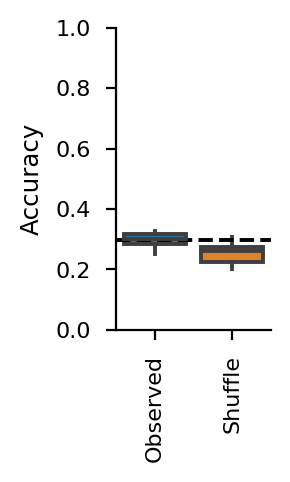

In [38]:
# plor accuracy
shuff_v=pd.DataFrame()
shuff_v['accuracy'] = out['acc']
shuff_v['shuff_accuracy'] = out['sacc']
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v, showfliers=False, showcaps=False, order=['accuracy', 'shuff_accuracy'])
plt.xticks(ticks=[0, 1], labels=['Observed', 'Shuffle'], rotation=90)
ax.set(ylabel='Accuracy')
plt.ylim([0,1])
plt.axhline(y=shuff_v['shuff_accuracy'].quantile(.95), xmin=0, xmax=1, ls='--', c='k')
sns.despine()

In [39]:
# is it significant?
loc = int(np.floor(len(shuff_v['shuff_accuracy'])*0.95))
a=np.argsort(shuff_v['shuff_accuracy'])
print('95th precentile of suffle is: ',shuff_v['shuff_accuracy'].quantile(.95)) # [a].to_numpy()[loc])
print('mean of decoding distribution is: ',np.mean(np.array(shuff_v['accuracy'])))
print ('mean shuffle accuracy is: ',np.mean(shuff_v['shuff_accuracy']))

95th precentile of suffle is:  0.2961748633879781
mean of decoding distribution is:  0.2961748633879781
mean shuffle accuracy is:  0.2530054644808743


# predicting individual

In [ ]:
#mice that have at least 3 phases and 10 repeptitions each
keep_mice = ['03_03', '02_01', '04_01', '01_03', '02_04', '01_01', '03_04', '04_02', '02_02', '04_03', '01_02', '03_01', '04_04', '02_03']

# add back labels
index_data = read_yaml(cpath+'/moseq2-index.yaml')

uuid_cage = {}
uuid_mouse = {}
uuid_phase = {}
uuid_rep = {}
for file in index_data['files']:
    if file['uuid'] in uuid_include:
        uuid_cage[file['uuid']] = file['metadata']['SubjectName'][:2]
        uuid_mouse[file['uuid']] = file['metadata']['SubjectName'][:5]
        uuid_rep[file['uuid']] = file['metadata']['SubjectName'][7:]
        uuid_phase[file['uuid']] = file['group']

uuid_include = [k for k, v in uuid_mouse.items() if v in keep_mice]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from moseq2_viz.model.util import parse_model_results, relabel_by_usage
from moseq2_viz.model.trans_graph import get_trans_graph_groups, get_group_trans_mats

# syllable threshold defined above. Uncomment isf you want to manually set
max_syllables = 58

# select a transition matrix normalization method
normalize = 'bigram' # options: bigram, columns, rows

# load your model
model_path = cpath+'/model-001-none.p'
model_data = parse_model_results(model_path)
model_data['labels'] = relabel_by_usage(model_data['labels'], count='usage')[0]
index_keep = [i for i, uuid in enumerate(model_data['keys']) if uuid in uuid_include]
model_data['labels']=np.array(model_data['labels'])[index_keep]
model_data['keys'] = np.array(model_data['keys'])[index_keep]
model_data['train_ll'] = np.array(model_data['train_ll'])[index_keep]
model_data['train_list'] = np.array(model_data['train_list'])[index_keep]
model_data['metadata']['groups'] = uuid_phase

mouse_data = [uuid_mouse[k] for k in model_data['keys']]
phase_data = [uuid_phase[k] for k in model_data['keys']]
rep_data = [uuid_rep[k] for k in model_data['keys']]

model_uuids = model_data.get('train_list',model_data['keys'])
label_group = [model_data['metadata']['groups'][k] for k in model_uuids]
group = sorted([g for g in list(set(label_group)) if 'NA' not in g])
rle_lbls = [np.array(rle(lbl)) for lbl in model_data['labels']]

trans_mats_permutations = np.load(cpath+'/tm_permute_58.npy')

trans_mats_permutations = np.mean(trans_mats_permutations, axis = 1)

tm_std = np.std(trans_mats_permutations, axis = 0) *2
tm_mean = np.mean(trans_mats_permutations, axis= 0)

tm_mean_plus = tm_mean + tm_std
tm_mean_minus = tm_mean - tm_std

trans_mats, usages = get_group_trans_mats(rle_lbls, label_group, group, max_syllables, normalize=normalize)
tm_real = np.array(trans_mats)

significant_tm = np.any([tm_real >= tm_mean_plus, tm_real <=tm_mean_minus], axis=0).astype(int)
tm_real_mean = np.mean(tm_real, axis = 0)
significant_tm_overall = np.any([tm_real_mean >= tm_mean_plus,  tm_real_mean <= tm_mean_minus], axis = 0)

select = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
          10,11,12,13,14,15,16,17,18,19,
          20,21,22,23,24,25,26,27,28,29,
          30,31,32,33,34,35,36,37,38,39,
          40,41,42,43,44,45,46,47,49] # syllable 49 is refered to in the manuscript and mean_df_female as 48 for clarity

tm_data_sig = []
y = []
for index, label in enumerate(model_data['labels']):
    tm = get_transition_matrix(label)[0][:max_syllables, :max_syllables]
    y.append(label_group[index])
    tm = tm * significant_tm_overall
    tm = tm[select][:, select]
    tm_data_sig.append(tm)
    
tm_data_sig = np.array(tm_data_sig)
tm_data_sig = np.reshape(tm_data_sig, (len(uuid_include), 49*49))
tm_data_sig =tm_data_sig/tm_data_sig.sum(1)[:,np.newaxis]
print(np.sum(tm_data_sig), np.all(np.isnan(tm_data_sig)))
tm_data_sig = pd.DataFrame(tm_data_sig)
tm_data_sig['group'] = phase_data
tm_data_sig['mouse'] = mouse_data
tm_data_sig['rep'] = rep_data

## individual identity decoder

In [43]:
it=1000
leave = 'rep'
predict='mouse'
minum=10

In [44]:
#decoder
clf = RandomForestClassifier(n_estimators = 250,class_weight='balanced')
out = defaultdict(list)
for i in tqdm(range(it)):
    sm = tm_data_sig.copy()
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]

        X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['y_true'].extend(a)
    out['y_pred'].extend(b)
    out['acc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

#shuffle
for i in tqdm(range(it)):
    sm = tm_data_sig.copy()
    sm['mouse'] = sm.groupby('rep')['mouse'].transform(np.random.permutation)
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]

        X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()
        #y_test = le.transform(y_test)

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['sy_true'].extend(a)
    out['sy_pred'].extend(b)
    out['sacc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

In [45]:
# save decoder results
decoder ='indv_decoder_bigrams'
with open(data_loc+decoder+'.dat', 'wb') as f:
    pickle.dump((out), f)

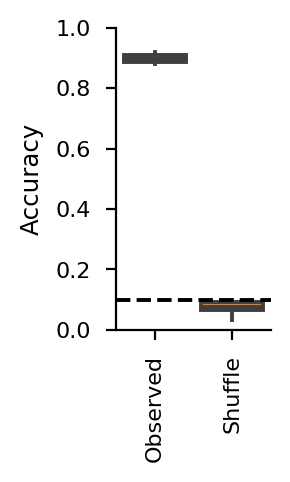

In [46]:
# plor accuracy
shuff_v=pd.DataFrame()
shuff_v['accuracy'] = out['acc']
shuff_v['shuff_accuracy'] = out['sacc']
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v, showfliers=False, showcaps=False, order=['accuracy', 'shuff_accuracy'])
plt.xticks(ticks=[0, 1], labels=['Observed', 'Shuffle'], rotation=90)
ax.set(ylabel='Accuracy')
plt.ylim([0,1])
plt.axhline(y=shuff_v['shuff_accuracy'].quantile(.95), xmin=0, xmax=1, ls='--', c='k')
sns.despine()

In [47]:
# is it significant?
loc = int(np.floor(len(shuff_v['shuff_accuracy'])*0.95))
a=np.argsort(shuff_v['shuff_accuracy'])
print('95th precentile of suffle is: ',shuff_v['shuff_accuracy'].quantile(.95)) # [a].to_numpy()[loc])
print('mean of decoding distribution is: ',np.mean(np.array(shuff_v['accuracy'])))
print ('mean shuffle accuracy is: ',np.mean(shuff_v['shuff_accuracy']))

95th precentile of suffle is:  0.09836065573770492
mean of decoding distribution is:  0.8978142076502733
mean shuffle accuracy is:  0.07486338797814208
